# Import 

In [1]:
import numpy as np
import re
import glob
import gc

from matplotlib import pyplot as plt
from tqdm import tqdm_notebook

from pypianoroll import Track, Multitrack
from pypianoroll.plot import plot_track

from telegramBot import TelegramBot

import librosa.display
import pretty_midi

# Utils 

In [63]:
LEARNING_DRUM_MAP = {
    0: dict(
        encoding=[[36]], #kick
        decoding=36,
    ),
    1:  dict(
        encoding=[[37, 44]], # snares
        decoding=38,
    ),
    2: dict(
        encoding=[[47, 63], [75, 82]], # cymbals
        decoding=54,
    ),
    3: dict(
        encoding=[[65, 72]], # toms
        decoding=65,
    ),
}

WINDOW_SIZE = 96

def dummy(x):
    return x

def note_gen(track):
    """
    yields notes from the song
    usage:
        gen = note_gen(pypianoroll.Track)
        next(gen)
    """
    for i in range(track.pianoroll.shape[0]):
        notes = track.pianoroll[i]
        hits = np.where(notes != 0)
        if np.sum(notes) != 0:
            yield hits
            
def load_midi_map(file_path):
    res = {}
    with open(file_path, 'r') as f:
        for line in f:
            midi_id = re.search(r'\d+', line).group(0)
            drum_name = line.replace(midi_id, '').strip()
            res[int(midi_id)] = drum_name
    return res

def search_folder_for_file_format(folder_path, file_format=r'\.rar$'):
    res = []
    for file in glob.iglob(folder_path + '**/*', recursive=True):
        if re.search(file_format, file) is not None:
            res.append(file)
    return res

def load_midi_files(root_path):
    res = []
    # walk recursively over root_path
    for file in tqdm_notebook(glob.iglob(root_path + '**/*', recursive=True)):
        # find midi files(.mid)
        if re.search(r'\.mid$', file) is not None:
            res.append(
                dict(midi=Multitrack(file), file_path=file)
            )
    return res

def collapse_index_range(drum_ranges):
    idx = []
    for indecies in drum_ranges:
        if len(indecies) == 1:
            idx.append(indecies[0])
        else:
            idx += list(range(*indecies))
    return idx

def binarize_array(arr):
    return (arr > 0) * 1

def threshold_array(array, threshold=.5):
    array[array <= threshold] = 0
    return array

def track_to_learn_seq(track, learning_map:'{key: {encoding=drum_range, decoding=drum}}'):
    track.binarize()
    track.trim_trailing_silence()
    
    seq = [0] * len(learning_map.keys())
    for key, drum_ranges in learning_map.items():
        idx = collapse_index_range(drum_ranges['encoding'])
        pre_collapsed_drum_lines = track.pianoroll[:, idx]
        collapsed_drum_lines = np.sum(pre_collapsed_drum_lines, axis=1)
        collapsed_drum_lines = binarize_array(collapsed_drum_lines)
        seq[key] = collapsed_drum_lines
    
    return np.array(seq)

def learn_seq_to_midi(seq, learning_map, return_midi=True):
    res = np.zeros([seq.shape[1], 128])
    seq = seq.T
    
    for drum_num, (coding, drum_coding) in zip(range(seq.shape[0]), learning_map.items()):
        res[:, drum_coding['decoding']] = seq[:, drum_num]
    
    if return_midi:
        return Track(pianoroll=res, program=0, is_drum=True)
    else:
        return res

def notes_used_in_track(track, midi_map=None):   
    notes = np.hstack([note for note in note_gen(track)])
    
    if midi_map is None:
        return np.unique(notes)
    else:
        res = {}
        for i in np.unique(notes):
            res[i] = midi_map[i]
        return res
    
def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(pm.pianoroll[start_pitch:end_pitch].T,
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))
    
def moving_window(seq, stride=1, window_len=WINDOW_SIZE):
    for time in range(0, seq.shape[1], stride):
        window = seq[:, time:(time + window_len)]
        
        if window.shape[1] < window_len:
            window = np.pad(window, [(0, 0), (0, window_len -  window.shape[1])], mode='constant')
            
            yield window
            break
        else:
            yield window

def make_dataset(midis, stride=1, window_len=WINDOW_SIZE, stack_songs=True):
    X = []
    for midi in tqdm_notebook(midis):
        track = midi['midi'].tracks[0]
        seq = track_to_learn_seq(track, LEARNING_DRUM_MAP)
        
        song = []
        for window in moving_window(seq=seq, stride=stride, window_len=window_len):
            song.append(window)
        
        X.append(np.array(song))
        
    if stack_songs: X = np.vstack(X)
        
    return X, X
        
def plot_learn_seq(seq, learning_map):
    track = Track(pianoroll=learn_seq_to_midi(seq, learning_map, return_midi=False), program=0, is_drum=True)
    plot_piano_roll(track, 0, track.pianoroll.shape[0])
    
def plot_model_notebook(model):
    from keras.utils import plot_model
    from IPython.display import Image
    plot_model(model)
    display(Image(retina=True, filename='model.png'))
    
def get_decoder(model, decoder_shape, decoder_layer):
    from keras.layers import Input
    from keras.models import Model
    
    encoded_output = Input(shape=decoder_shape)

    decoder = model.layers[decoder_layer](encoded_output)
    if decoder_layer != - 1:
        for layer in model.layers[decoder_layer + 1:]:
            decoder = layer(decoder)

    decoder = Model(inputs=encoded_output, outputs=decoder)
    return decoder

def build_intermediate_model(model, start_layer_index):
    from keras.layers import Input
    from keras.models import Model
    
    input_layer = model.layers[start_layer_index]
    
    inputs = Input(shape=input_layer.input_shape[1:])

    new_model = model.layers[start_layer_index](inputs)
    if start_layer_index != - 1:
        for layer in model.layers[start_layer_index + 1:]:
            new_model = layer(new_model)

    new_model = Model(inputs=inputs, outputs=new_model)
    return new_model

def get_encoder(model, end_of_encoder):
    from keras.models import Model
    return Model(inputs=model.inputs, outputs=model.layers[end_of_encoder].output)

def save_drum_track(track, name='generated.mid'):
    Multitrack(tracks=[track]).write(name)
    
def drum_distribution(dataset:'(batch_size, drum_line, time_step)'):
    return np.sum(dataset, axis=(0, 2)) / np.sum(dataset)

def calc_midi_sparsity(dataset:'(batch_size, drum_line, time_step)', per_drum=False):
    if per_drum:
        inputs_per_sample = np.sum(dataset, axis=(2))
        max_inputs = X.shape[2]
        
    else:
        inputs_per_sample = np.sum(dataset, axis=(1, 2))
        max_inputs = np.prod(X.shape[1:])
        
    return inputs_per_sample / max_inputs

def plot_history(history, metrics=['loss']):
    hist = history.history
    
    for metric in metrics:
        legend = [metric, 'val_' + metric]
        [plt.plot(hist[to_plot]) for to_plot in legend]
        plt.legend(legend)
        plt.show()
        
def now(format_="%Y-%m-%d %H:%M"):
    from datetime import datetime
    return datetime.now().strftime(format_)

def purge_directory(directory):
    import shutil
    import os
    if directory[0] == '/':
        raise Exception('check the dir boy')
    try:
        shutil.rmtree(directory)
    except FileNotFoundError:
        pass
    
    os.mkdir(directory)
    
def in_top_k(arr, k, return_values=False):
    idx = np.argsort(arr)[-k:]
    if return_values:
        return np.array(arr)[idx]
    else:
        return idx
    
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed

def iter_per_epoch(size, batch_size):
    return size // batch_size

# Data Load 

In [104]:
midi_map = load_midi_map('./midi_map.txt')
midi_map

{36: 'Kick',
 37: 'Snare Rimshot L',
 38: 'Snare Open Hit L',
 39: 'Snare Rimshot R',
 40: 'Snare Open Hit R',
 41: 'Snare Shallow Rimshot',
 42: 'Snare Side Stick',
 43: 'Snare Shallow Hit',
 44: 'Snare Rim Click',
 45: 'Ride Pearl (double)',
 46: 'Cymbal 1 (double)',
 47: 'Cowbell - Mid Tom',
 48: 'HH Pedal Closed',
 49: 'HH Closed 1 Pearl',
 50: 'HH Closed 1 Shaft',
 51: 'HH Closed 2 Pearl',
 52: 'HH Closed 2 Shaft',
 53: 'HH Closed Bell',
 54: 'HH Open A',
 55: 'HH Open B',
 56: 'HH Open C',
 57: 'HH Open D',
 58: 'HH Open Bell',
 59: 'HH Pedal Open',
 60: 'Ride Pearl',
 61: 'Ride Bell',
 62: 'Ride Shaft',
 63: 'Ride Choke',
 64: '',
 65: 'Tom 4',
 66: 'Tom 4 Rim',
 67: 'Tom 3',
 68: 'Tom 3 Rim',
 69: 'Tom 2',
 70: 'Tom 2 Rim',
 71: 'Tom 1',
 72: 'Tom 1 Rim',
 73: '',
 74: '',
 75: 'Sticks',
 76: '',
 77: 'Cymbal 1',
 78: 'Cymbal 1 Choke',
 79: 'Cymbal 2',
 80: 'Cymbal 2 Choke',
 81: 'Cymbal 3',
 82: 'Cymbal 3 Choke'}

In [6]:
midis = load_midi_files('./_datasets/')

In [102]:
for midi_mtrack in midis:
    track = midi_mtrack['midi'].tracks[0]
    file = midi_mtrack['file_path']
    break

In [105]:
notes_used_in_track(track, midi_map)

{36: 'Kick',
 38: 'Snare Open Hit L',
 45: 'Ride Pearl (double)',
 58: 'HH Open Bell',
 61: 'Ride Bell',
 67: 'Tom 3'}

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x25dc706c208>)

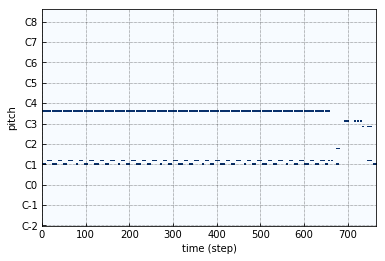

In [106]:
track.plot()

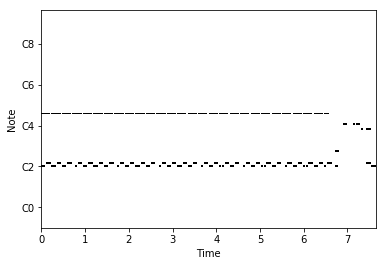

In [107]:
plot_piano_roll(track, 0, track.pianoroll.shape[0])

In [108]:
seq = track_to_learn_seq(track, LEARNING_DRUM_MAP)

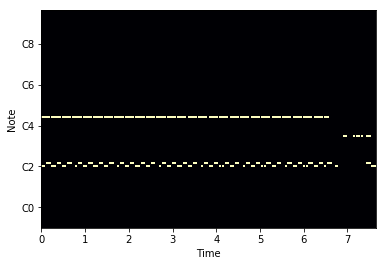

In [109]:
track = learn_seq_to_midi(seq, LEARNING_DRUM_MAP)
plot_piano_roll(track, 0, track.pianoroll.shape[0])


In [12]:
seq.shape

(4, 766)

## Make Dataset 

In [4]:
from sklearn.model_selection import train_test_split
midis = load_midi_files('./_datasets/')

X, Y = make_dataset(midis, stride=1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.1, shuffle=True)

X.shape

(1152777, 4, 96)

## Make seq dataset

In [22]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

midis = load_midi_files('./_datasets/')

X, Y = make_dataset(midis, stride=96, stack_songs=False)

seq_lengths = [x.shape[0] for x in X]
maxlen = np.max(seq_lengths)

X = pad_sequences(X, maxlen=maxlen, padding='post')
Y = X

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.1, shuffle=True)

X.shape

(2486, 100, 4, 96)

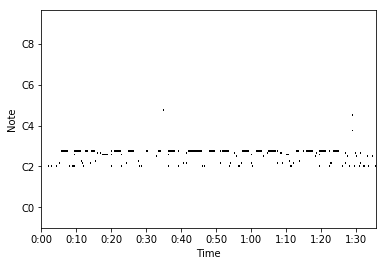

In [45]:
index = 2379
plot_piano_roll(midis[index]['midi'].tracks[0], 0, midis[index]['midi'].tracks[0].pianoroll.shape[0])

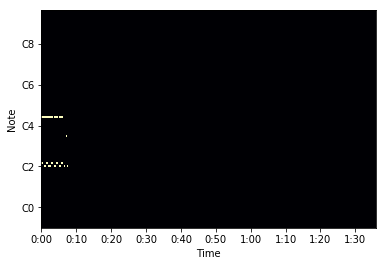

In [30]:
track = learn_seq_to_midi(np.hstack(X[0]), LEARNING_DRUM_MAP)
plot_piano_roll(track, 0, track.pianoroll.shape[0])

## Data analysis

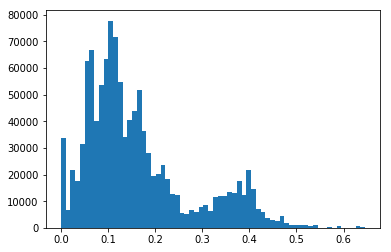

In [69]:
plt.hist(calc_midi_sparsity(X, False), bins=64);

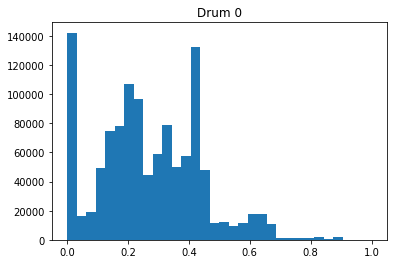

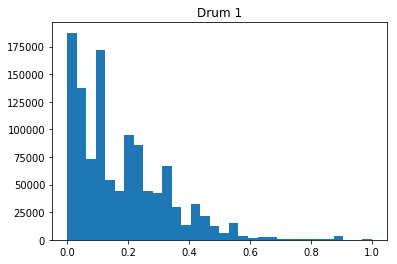

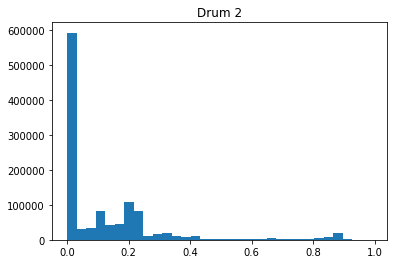

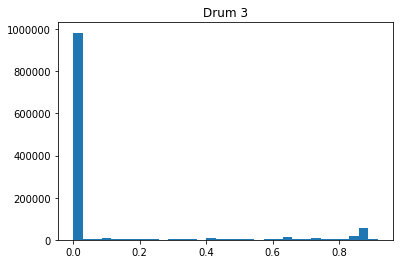

In [73]:
sparcity_data = calc_midi_sparsity(X, True)

for i in range(X.shape[1]):
    plt.hist(sparcity_data[:, i], bins=32)
    plt.title('Drum {}'.format(i))
    plt.show()

# AutoEncoder

In [281]:
import keras.backend as K

from keras.models import Sequential, Model
from keras.layers import Input, Dense, TimeDistributed, Reshape, Permute, Flatten, Dropout
from keras.optimizers import Adam
from keras_tqdm import TQDMNotebookCallback
from keras.utils import plot_model

if len(K.tensorflow_backend._get_available_gpus()) > 0:
    print('Using GPU')

INPUT_SHAPE = [len(LEARNING_DRUM_MAP), WINDOW_SIZE]

do_params = dict(
    layer_1=.1,
    layer_2=.05,
    layer_3=.1
)

verbose = True

if verbose: print('Input shape:', INPUT_SHAPE)
    
# model = Sequential([
#     Flatten(input_shape=INPUT_SHAPE, name='flatten_input'),
#     Dense(64, activation='relu', name='encoder_1'),
#     Dense(32, activation='relu', name='encoder_2'),
#     Dense(64, activation='relu', name='decoder'),
#     Dense(np.product(INPUT_SHAPE), activation='sigmoid', name='flat_output'),
#     Reshape(INPUT_SHAPE, name='output')
# ])

input_ = Input(shape=INPUT_SHAPE)
flatten_input = Flatten(name='flatten_input')(input_)

encoder_1 = Dense(256, activation='elu', name='encoder_1')(flatten_input)
encoder_1 = Dropout(do_params['layer_1'])(encoder_1)
    
encoder_2 = Dense(128, activation='elu', name='encoder_2')(encoder_1)
encoder_2 = Dropout(do_params['layer_2'])(encoder_2)
    
decoder_1 = Dense(256, activation='elu', name='decoder_1')(encoder_2)
decoder_1 = Dropout(do_params['layer_3'])(decoder_1)

flat_output = Dense(np.product(INPUT_SHAPE), activation='sigmoid', name='flat_output')(decoder_1)
output = Reshape(INPUT_SHAPE, name='output')(flat_output)

model = Model(inputs=input_, outputs=output)

decoder = get_decoder(model, decoder_shape=(128,), decoder_layer=-4)

model.compile(
    optimizer=Adam(lr=0.01, decay=0.0001), # decay?
    loss='binary_crossentropy',
    metrics=['mse', 'mae']
)

history = model.fit(X_train, X_train, 
                    batch_size=128, epochs=4, 
                    validation_split=.2, 
                    verbose=0, callbacks=[TQDMNotebookCallback()])

model.evaluate(X_test, y_test, verbose=0)

Using GPU
Input shape: [4, 96]


[0.018723930468583946, 0.005053832035793008, 0.012021777450885313]

## Saver

In [323]:
from keras.models import save_model

save_model(model, './models/wider_ae.mdl')

# AutoEncoder w/ Conv

In [429]:
import keras.backend as K

from keras.models import Sequential, Model
from keras.layers import Input, Dense, TimeDistributed, Reshape, Permute, Flatten, Dropout, Activation
from keras.layers import Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras_tqdm import TQDMNotebookCallback
from keras.utils import plot_model

if len(K.tensorflow_backend._get_available_gpus()) > 0:
    print('Using GPU')

INPUT_SHAPE = [len(LEARNING_DRUM_MAP), WINDOW_SIZE]

do_params = dict(
    layer_1=.1,
    layer_2=.1,
    layer_3=.1
)

verbose = True

if verbose: print('Input shape:', INPUT_SHAPE)

input_ = Input(shape=INPUT_SHAPE)
add_channel = Reshape(target_shape=(*INPUT_SHAPE, 1))(input_)

conv_1 = Conv2D(4, (4, 1), strides=(1, 1), padding='same', activation='relu')(add_channel)
# bn_1 = BatchNormalization(momentum=.95)(conv_1)
# conv_1 = Activation('relu')(bn_1)

# max_pool_1 = MaxPool2D((2, 2), strides=(1, 1), padding='same')(conv_1)

flatten_input = Flatten(name='flatten_input')(conv_1)

encoder_1 = Dense(256, activation='elu', name='encoder_1')(flatten_input)
encoder_1 = Dropout(do_params['layer_1'])(encoder_1)
    
encoder_2 = Dense(128, activation='elu', name='encoder_2')(encoder_1)
encoder_2 = Dropout(do_params['layer_2'])(encoder_2)
    
decoder_1 = Dense(256, activation='elu', name='decoder_1')(encoder_2)
decoder_1 = Dropout(do_params['layer_3'])(decoder_1)

flat_output = Dense(np.product(INPUT_SHAPE), activation='sigmoid', name='flat_output')(decoder_1)
output = Reshape(INPUT_SHAPE, name='output')(flat_output)

model = Model(inputs=input_, outputs=output)

decoder = get_decoder(model, decoder_shape=(128,), decoder_layer=-4)

model.compile(
    optimizer=Adam(lr=0.01, decay=10 ** -4), # decay?
    loss='binary_crossentropy',
    metrics=['mse', 'mae']
)

history = model.fit(X_train, X_train, 
                    batch_size=128, epochs=4, 
                    validation_split=.2, 
                    verbose=0, callbacks=[TQDMNotebookCallback()])

model.evaluate(X_test, y_test, verbose=0)

Using GPU
Input shape: [4, 96]


[0.01508150643113287, 0.003844890271543302, 0.01044061029664913]

## Saver

In [433]:
from keras.models import save_model, load_model

save_model(model, './models/conv_ae_mse_0038_good_gen.mdl')

# VAE

In [12]:
import keras.backend as K

BATCH_SIZE = 256
LATENT_SIZE = 128

VAE_PARAM_1 = 1 # std
VAE_PARAM_2 = .005 # KL regularization

NAME = 'ConvVAE'

from keras.models import Sequential, Model, load_model, save_model
from keras.layers import Input, Dense, TimeDistributed, Reshape, Permute, Flatten, Dropout, Activation, Lambda
from keras.layers import Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import TensorBoard
from keras.utils import plot_model
from keras import objectives

def sampling(args):
    z_mean, z_log_var = args
    shape = K.shape(z_mean)
    epsilon = K.random_normal(shape=shape, mean=0, stddev=VAE_PARAM_1)
    return z_mean + K.exp(.5 * z_log_var) * epsilon

def vae_loss(y_true, y_pred):
    recon = K.sum(objectives.binary_crossentropy(y_pred, y_true), axis=1)
    kl = VAE_PARAM_2 * K.sum(K.exp(log_sigma) + K.square(mu) - 1. - log_sigma, axis=1)
    return recon + kl

if len(K.tensorflow_backend._get_available_gpus()) > 0:
    print('Using GPU')

INPUT_SHAPE = [len(LEARNING_DRUM_MAP), WINDOW_SIZE]

do_params = dict(
    layer_1=.2,
    layer_2=.1,
    layer_3=.2
)

general_params = dict(
    kernel_initializer='he_normal',
)

verbose = True

if verbose: print('Input shape:', INPUT_SHAPE)
    
K.clear_session()

# Inputs
input_ = Input(shape=INPUT_SHAPE)
add_channel = Reshape(target_shape=(*INPUT_SHAPE, 1))(input_)

# Conv Part
conv_1 = Conv2D(16, (4, 1), strides=(1, 1), padding='same', name='conv_1', **general_params)(add_channel)
# conv_1 = BatchNormalization(momentum=.95)(conv_1) # off
conv_1 = Activation('elu')(conv_1)

# max_pool_1 = MaxPool2D((2, 2), strides=(1, 1), padding='same')(conv_1)

flatten_input = Flatten(name='flatten_input')(conv_1)

encoder_1 = Dense(256, activation='elu', name='encoder_1', **general_params)(flatten_input)
encoder_1 = Dropout(do_params['layer_1'])(encoder_1)

## VAE part
mu = Dense(LATENT_SIZE, activation='linear', **general_params)(encoder_1)
log_sigma = Dense(LATENT_SIZE, activation='linear', **general_params)(encoder_1)

# Sample z ~ Q(z|X)
z = Lambda(sampling, output_shape=(LATENT_SIZE,))([mu, log_sigma])

decoder = Sequential([
    Dense(256, activation='elu', name='decoder_2', **general_params),
    Dropout(do_params['layer_3']),
    Dense(np.product(INPUT_SHAPE), activation='sigmoid', name='flat_output', **general_params),
    Reshape(INPUT_SHAPE, name='output'),
])

output = decoder(z)

model = Model(inputs=input_, outputs=output)

model.compile(
    optimizer=Adam(lr=0.001, decay=10 ** -5),
    loss=vae_loss,
    metrics=['mse', 'mae']
)

tb_log_dir = './tb_logs/{}/{}'.format(NAME, now("%Y-%m-%d %H_%M"))

callbacks = [
    TQDMNotebookCallback(),
    TensorBoard(log_dir=tb_log_dir),
]

history = model.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, epochs=16, 
                    validation_split=.1, shuffle=True,
                    verbose=0, callbacks=callbacks)

res = model.evaluate(X_test, y_test, verbose=0)

msg = 'Done! Loss: {}, MSE: {}, MAE: {}'.format(*res)

TelegramBot().send(msg)
print(msg)

Using GPU
Input shape: [4, 96]


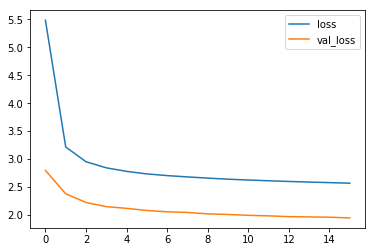

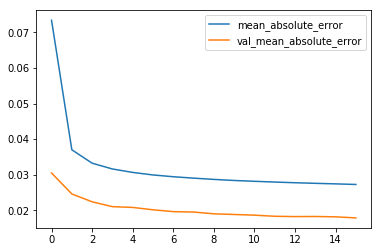

In [6]:
def plot_history(history, metrics=['loss', 'mean_absolute_error']):
    hist = history.history
    
    for metric in metrics:
        legend = [metric, 'val_' + metric]
        [plt.plot(hist[to_plot]) for to_plot in legend]
        plt.legend(legend)
        plt.show()
        
plot_history(history)

## Saver 

In [24]:
from keras.models import save_model, load_model

save_model(model, './models/{}_mse_0155.mdl'.format(NAME))

## Load 

In [11]:
from keras.models import load_model
import keras.backend as K
import keras.objectives as objectives

VAE_PARAM_2 = .01

def vae_loss(y_true, y_pred):
    recon = K.sum(objectives.binary_crossentropy(y_pred, y_true), axis=1)
    kl = VAE_PARAM_2 * K.sum(K.exp(log_sigma) + K.square(mu) - 1. - log_sigma, axis=1)
    return recon + kl

model = load_model('./models/conv_vae_one_var_mse_0155.mdl', custom_objects=dict(VAE_PARAM_1=1, vae_loss=vae_loss))

NameError: name 'log_sigma' is not defined

# VAE w/ KLDivengence Layer

In [6]:
import keras.backend as K

BATCH_SIZE = 2048
LATENT_SIZE = 128

NAME = 'ConvVAE_KLLayer'

from keras.models import Sequential, Model, load_model, save_model
from keras.layers import Input, Dense, TimeDistributed, Reshape, Permute, Flatten, Dropout, Activation, Lambda
from keras.layers import Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.utils import plot_model
from keras import objectives
from custom_layers import KLDivergenceLayer

def sampling(args):
    z_mean, z_log_var = args
    shape = K.shape(z_mean)
    epsilon = K.random_normal(shape=shape, mean=0, stddev=1)
    return z_mean + K.exp(.5 * z_log_var) * epsilon

def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

if len(K.tensorflow_backend._get_available_gpus()) > 0:
    print('Using GPU')

INPUT_SHAPE = [len(LEARNING_DRUM_MAP), WINDOW_SIZE]

do_params = dict(
    layer_1=.2,
    layer_2=.1,
    layer_3=.2
)

general_params = dict(
    kernel_initializer='he_normal',
)

verbose = True

if verbose: print('Input shape:', INPUT_SHAPE)
    
K.clear_session()

# Inputs
input_ = Input(shape=INPUT_SHAPE)
add_channel = Reshape(target_shape=(*INPUT_SHAPE, 1))(input_)

# Conv Part
conv_1 = Conv2D(16, (4, 1), strides=(1, 1), padding='same', name='conv_1', **general_params)(add_channel)
# conv_1 = BatchNormalization(momentum=.95)(conv_1) # off
conv_1 = Activation('elu')(conv_1)

conv_1 = MaxPool2D((4, 1), strides=(1, 1), padding='same')(conv_1)

flatten_input = Flatten(name='flatten_input')(conv_1)

encoder_1 = Dense(256, activation='elu', name='encoder_1', **general_params)(flatten_input)
encoder_1 = Dropout(do_params['layer_1'])(encoder_1)

## VAE part
mu = Dense(LATENT_SIZE, activation='linear', **general_params)(encoder_1)
log_var = Dense(LATENT_SIZE, activation='linear', **general_params)(encoder_1)

mu, log_var = KLDivergenceLayer(.005)([mu, log_var])

# Sample z ~ Q(z|X)
z = Lambda(sampling, output_shape=(LATENT_SIZE,))([mu, log_var])

encoder = Model(inputs=input_, outputs=z)

decoder = Sequential([
    Dense(256, activation='elu', name='decoder_2', **general_params),
    Dropout(do_params['layer_3']),
    Dense(np.product(INPUT_SHAPE), activation='sigmoid', name='flat_output', **general_params),
    Reshape(INPUT_SHAPE, name='output'),
])

output = decoder(z)

model = Model(inputs=input_, outputs=output)

model.compile(
    optimizer=Adam(lr=0.001, decay=10 ** -5),
    loss=nll,
    metrics=['mse', 'mae']
)

tb_log_dir = './tb_logs/{}/{}'.format(NAME, now("%Y-%m-%d %H_%M"))
save_path = './_checkpoints/'

purge_directory(save_path)

callbacks = [
    TQDMNotebookCallback(),
    TensorBoard(log_dir=tb_log_dir),
    ModelCheckpoint(save_path + 'checkpoint-{epoch:02d}-{val_loss:.4f}.mdl', monitor='val_loss', save_best_only=True),
]

history = model.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, epochs=128, 
                    validation_split=.1, shuffle=True,
                    verbose=0, callbacks=callbacks)

res = model.evaluate(X_test, y_test, verbose=0)

msg = 'Done! Loss: {}, MSE: {}, MAE: {}'.format(*res)

TelegramBot().send(msg)
print(msg)

Using GPU
Input shape: [4, 96]


KeyboardInterrupt: 

## Saver

In [10]:
from keras.models import save_model, load_model

save_model(model, f'./models/{NAME}_test.mdl')

## Loader 

In [17]:
import keras.backend as K

from keras.models import load_model
from custom_layers import KLDivergenceLayer

def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

K.clear_session()

model = load_model('./models/ConvVAE_KLLayer_mse_00287.mdl', custom_objects=dict(KLDivergenceLayer=KLDivergenceLayer, nll=nll))
encoder = get_encoder(model, -2)
decoder = build_intermediate_model(model, start_layer_index=-1)

Using TensorFlow backend.


# VAE w/ KL and Batch Norm

In [5]:
import keras.backend as K

BATCH_SIZE = 2 ** 11
LATENT_SIZE = 128

NAME = 'ConvVAE_KLLayer_BN_CLR'

from keras.models import Sequential, Model, load_model, save_model
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Activation, Lambda
from keras.layers import Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam, SGD
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.utils import plot_model
from keras import objectives

from keras_cyclic_lr import CyclicLR
from keras_1cycle import OneCycleLR
from custom_layers import KLDivergenceLayer

def sampling(args):
    z_mean, z_log_var = args
    shape = K.shape(z_mean)
    epsilon = K.random_normal(shape=shape, mean=0, stddev=1)
    return z_mean + K.exp(.5 * z_log_var) * epsilon

def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

if len(K.tensorflow_backend._get_available_gpus()) > 0:
    print('Using GPU')

INPUT_SHAPE = [len(LEARNING_DRUM_MAP), WINDOW_SIZE]

do_params = dict(
    layer_1=.2,
    layer_2=.2,
)

general_params = dict(
    kernel_initializer='he_normal',
)

verbose = True

if verbose: print('Input shape:', INPUT_SHAPE)
    
K.clear_session()

# Inputs
input_ = Input(shape=INPUT_SHAPE)

encoder = Sequential([
    Reshape(target_shape=(*INPUT_SHAPE, 1)),
    
    Conv2D(4, (4, 1), strides=(1, 1), padding='same', name='conv_1', **general_params), # used to be 16
    BatchNormalization(),
    Activation('elu'),
    
    Flatten(name='flatten_input'),
    
    Dense(256, name='encoder_1', **general_params),
    BatchNormalization(),
    Activation('elu'),
    Dropout(do_params['layer_1']),
])

encoder_1 = encoder(input_)

## VAE part
mu = Dense(LATENT_SIZE, activation='linear', **general_params)(encoder_1)
log_var = Dense(LATENT_SIZE, activation='linear', **general_params)(encoder_1)

mu, log_var = KLDivergenceLayer(.005)([mu, log_var])

# Sample z ~ Q(z|X)
z = Lambda(sampling, output_shape=(LATENT_SIZE,))([mu, log_var])

encoder = Model(inputs=input_, outputs=z)

decoder = Sequential([
    Dense(256, name='decoder_2', **general_params),
    BatchNormalization(),
    Activation('elu'),
    Dropout(do_params['layer_2']),
    
    Dense(np.product(INPUT_SHAPE), activation='sigmoid', name='flat_output', **general_params),
    Reshape(INPUT_SHAPE, name='output'),
])

output = decoder(z)

model = Model(inputs=input_, outputs=output)


optimizers = dict(
    adam=Adam(lr=3e-4, decay=0),
    sgd=SGD(lr=1e-2, momentum=0.95, nesterov=True),
)

model.compile(
    optimizer=optimizers['sgd'],
    loss=nll,
    metrics=['mse', 'mae']
)

tb_log_dir = './tb_logs/{}/{}'.format(NAME, now("%Y-%m-%d %H_%M"))
save_path = './_checkpoints/'

purge_directory(save_path)

callbacks = [
    TQDMNotebookCallback(),
    TensorBoard(log_dir=tb_log_dir, write_graph=False),
    ModelCheckpoint(save_path + 'checkpoint-{epoch:02d}-{val_loss:.4f}.mdl', monitor='val_loss', save_best_only=True),
#     CyclicLR(base_lr=1e-5, max_lr=3e-4, step_size=2000), # adam
    CyclicLR(base_lr=1e-3, max_lr=1e-2, step_size=2000),
#     OneCycleLR(max_lr=.01, verbose=False)
]

history = model.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, epochs=128, 
                    validation_split=.1, shuffle=True,
                    verbose=0, callbacks=callbacks)

res = model.evaluate(X_test, y_test, verbose=0)

msg = 'Done! Loss: {}, MSE: {}, MAE: {}'.format(*res)

TelegramBot().send(msg)
print(msg)

Using TensorFlow backend.


Using GPU
Input shape: [4, 96]


KeyboardInterrupt: 

### LRFinder 

In [6]:
from keras_lr_finder import LRFinder

lr_finder = LRFinder(model)

lr_finder.find(X_train, y_train, start_lr=1e-6, end_lr=5, batch_size=BATCH_SIZE, epochs=4, verbose=0, callbacks=[TQDMNotebookCallback()])

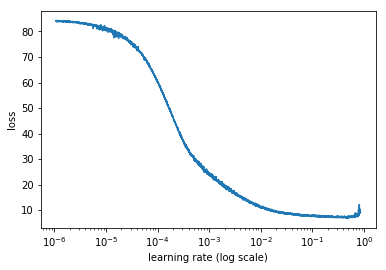

In [7]:
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)

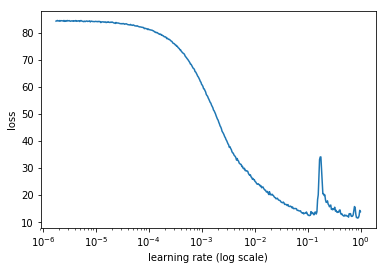

In [7]:
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)

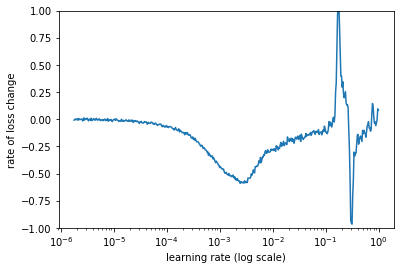

In [9]:
lr_finder.plot_loss_change(sma=20, n_skip_beginning=20, n_skip_end=5, y_lim=(-1, 1))

## Saver

In [5]:
from keras.models import save_model

save_model(model, f'./models/{NAME}_mse_00217.mdl')

## Loader

In [17]:
import keras.backend as K

from keras.models import load_model
from custom_layers import KLDivergenceLayer

K.clear_session()

def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

model = load_model('./models/ConvVAE_KLLayer_BN_mse_00217.mdl', custom_objects=dict(KLDivergenceLayer=KLDivergenceLayer, nll=nll))
encoder = get_encoder(model, -2)
decoder = build_intermediate_model(model, start_layer_index=-1)

In [7]:
model.layers[1].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 4, 96, 1)          0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 4, 96, 4)          20        
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 96, 4)          16        
_________________________________________________________________
activation_1 (Activation)    (None, 4, 96, 4)          0         
_________________________________________________________________
flatten_input (Flatten)      (None, 1536)              0         
_________________________________________________________________
encoder_1 (Dense)            (None, 256)               393472    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
__________

# GRU VAE

In [18]:
import keras.backend as K

BATCH_SIZE = 64
LATENT_SIZE = 128

NAME = 'ConvVAE_GRU'

from keras.models import Sequential, Model, load_model, save_model
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Activation, Lambda, Permute
from keras.layers import Conv2D, MaxPool2D, BatchNormalization, TimeDistributed, CuDNNGRU, GRU, LSTM

from keras.optimizers import Adam, SGD

from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras import objectives

from keras_cyclic_lr import CyclicLR
from keras_1cycle import OneCycleLR
from custom_layers import KLDivergenceLayer
from signalStopping import SignalHandler

def sampling(args):
    z_mean, z_log_var = args
    shape = K.shape(z_mean)
    epsilon = K.random_normal(shape=shape, mean=0, stddev=1)
    return z_mean + K.exp(.5 * z_log_var) * epsilon

def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

def expand_dims(x):
    return K.expand_dims(x, -1)

if len(K.tensorflow_backend._get_available_gpus()) > 0:
    print('Using GPU')

INPUT_SHAPE = [None, len(LEARNING_DRUM_MAP), WINDOW_SIZE]

do_params = dict(
    layer_1=.2,
    layer_2=.2,
)

general_params = dict(
    kernel_initializer='he_normal',
)

verbose = True

if verbose: print('Input shape:', INPUT_SHAPE)
    
K.clear_session()

# Inputs
input_ = Input(shape=INPUT_SHAPE)

input_ = Input(shape=INPUT_SHAPE)
add_channel = Lambda(expand_dims)(input_)

# Conv Part
conv_1 = TimeDistributed(Conv2D(4, (4, 1), strides=(1, 1), padding='same', name='conv_1', **general_params))(add_channel)
conv_1 = BatchNormalization()(conv_1)
conv_1 = Activation('elu')(conv_1)

# conv_1 = MaxPool2D((4, 1), strides=(1, 1), padding='same')(conv_1)

flatten_input = TimeDistributed(Flatten(name='flatten_input'))(conv_1)

encoder_1 = Dense(256, name='encoder_1', **general_params)(flatten_input)
encoder_1 = BatchNormalization()(encoder_1)
encoder_1 = Activation('elu')(encoder_1)

encoder_1 = Dropout(do_params['layer_1'])(encoder_1)

## VAE part
mu = Dense(LATENT_SIZE, activation='linear', **general_params)(encoder_1)
log_var = Dense(LATENT_SIZE, activation='linear', **general_params)(encoder_1)

mu, log_var = KLDivergenceLayer(.005)([mu, log_var])

# Sample z ~ Q(z|X)
z = Lambda(sampling)([mu, log_var])

z_gru = GRU(128, return_sequences=True, **general_params)(z)

encoder = Model(inputs=input_, outputs=z_gru)

decoder_1 = Dense(256, name='decoder_1', **general_params)(z_gru)
decoder_1 = BatchNormalization()(decoder_1)
decoder_1 = Activation('elu')(decoder_1)
decoder_1 = Dropout(do_params['layer_2'])(decoder_1)

output_flat = Dense(np.product(INPUT_SHAPE[1:]), activation='sigmoid', name='flat_output', **general_params)(decoder_1)
output = TimeDistributed(Reshape(INPUT_SHAPE[1:], name='output'))(output_flat)

model = Model(inputs=input_, outputs=output)

optimizers = dict(
    adam=Adam(lr=3e-4, decay=0),
    sgd=SGD(lr=1e-2, momentum=0.95, nesterov=True),
)

model.compile(
    optimizer=optimizers['adam'],
    loss=nll,
    metrics=['mse', 'mae']
)

tb_log_dir = './tb_logs/{}/{}'.format(NAME, now("%Y-%m-%d %H_%M"))
save_path = './_checkpoints/'

purge_directory(save_path)

callbacks = [
    SignalHandler(),
    TQDMNotebookCallback(),
    TensorBoard(log_dir=tb_log_dir, write_graph=False),
    ModelCheckpoint(save_path + 'checkpoint-{epoch:02d}-{val_loss:.4f}.mdl', monitor='val_loss', save_best_only=True),
    CyclicLR(base_lr=1e-4, max_lr=1e-3, step_size=4 * iter_per_epoch(X_train.shape[0], BATCH_SIZE)), # adam
#     CyclicLR(base_lr=1e-3, max_lr=1e-2, step_size=2000),
#     OneCycleLR(max_lr=.01, verbose=False)
]

# history = model.fit(X_train, y_train, 
#                     batch_size=BATCH_SIZE, epochs=128,
#                     validation_split=.1, shuffle=True,
#                     verbose=0, callbacks=callbacks)

# res = model.evaluate(X_test, y_test, verbose=0)

# msg = 'Done! Loss: {}, MSE: {}, MAE: {}'.format(*res)

# TelegramBot().send(msg)
# print(msg)

Using GPU
Input shape: [None, 4, 96]


NameError: name 'X_train' is not defined

### LRFinder 

In [20]:
from keras_lr_finder import LRFinder

lr_finder = LRFinder(model)

lr_finder.find(X_train, y_train, start_lr=1e-8, end_lr=5, batch_size=BATCH_SIZE, epochs=10, verbose=0, callbacks=[TQDMNotebookCallback()])

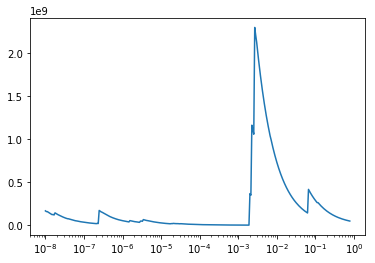

In [44]:
x = lr_finder.lrs
y = lr_finder.losses

y_sm = smooth(y, .95)

plt.plot(x, y_sm)
plt.xscale('log')

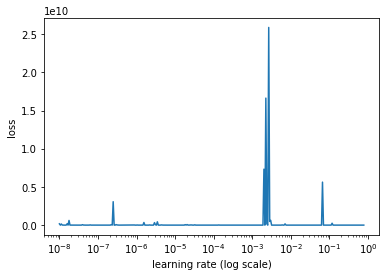

In [36]:
lr_finder.plot_loss(n_skip_beginning=0, n_skip_end=2)
# plt.ylim(-1e4, 1e5)

## Saver

In [52]:
from keras.models import save_model

save_model(model, f'./models/{NAME}_mse_00231.mdl')

## Loader 

In [55]:
decoder = build_intermediate_model(model, start_layer_index=-7)

(None, None, 128)


In [19]:
import keras.backend as K

from keras.models import load_model
from custom_layers import KLDivergenceLayer

def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

# K.clear_session()

model_old = load_model('./models/ConvVAE_GRU_mse_00231.mdl', custom_objects=dict(KLDivergenceLayer=KLDivergenceLayer, nll=nll))
# encoder = get_encoder(model, -2)
# decoder = build_intermediate_model(model, start_layer_index=-1)

# Test Models

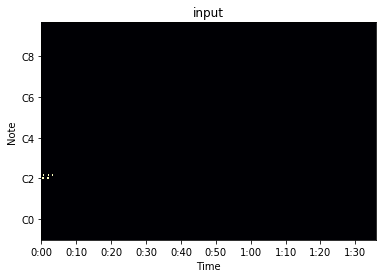

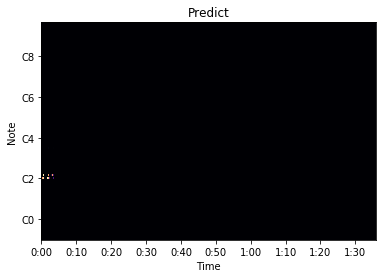

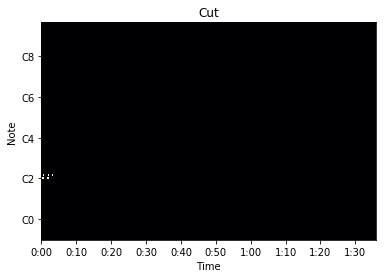

In [44]:
def test_AE(sample, model, save=True, save_orig_name='orig.mid', threshold=.99, decoding=False, sequence=False):
    deco = lambda x: np.hstack(x) if sequence else dummy(x)
    if not decoding:
        plot_learn_seq(deco(sample), LEARNING_DRUM_MAP)
        plt.title('input')
        plt.show()
    
        if save: save_drum_track(learn_seq_to_midi(deco(sample), LEARNING_DRUM_MAP), name=save_orig_name)

    try:
        predict = model.predict(sample)[0]
    except ValueError:
        predict = model.predict(np.array([sample]))[0]
    
    plot_learn_seq(deco(predict), LEARNING_DRUM_MAP)
    plt.title('Predict')
    plt.show()

    predict_cut = binarize_array(threshold_array(deco(predict), threshold=threshold))

    if save: save_drum_track(learn_seq_to_midi(predict_cut, LEARNING_DRUM_MAP))

    plot_learn_seq(predict_cut, LEARNING_DRUM_MAP)
    plt.title('Cut')
    plt.show()
    
x_test = np.array(X_test[16])

# x_test[:, 96 // 2:] = binarize_array(threshold_array(np.random.rand(4, 96 // 2), .5))

test_AE(x_test, model, decoding=False, threshold=.5, sequence=True)

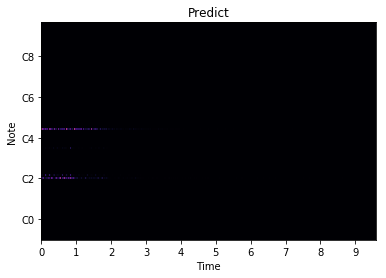

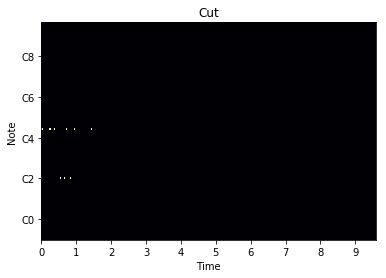

In [80]:
shape = (10, 128)
seed = threshold_array(np.random.rand(*shape), .0)
# seed = np.ones(shape)

test_AE(seed, decoder, decoding=True, threshold=.04, sequence=True)

In [11]:
def generate_random_song(decoder, bars, threshold=.5):
    rand_predict = decoder.predict(np.random.rand(bars, decoder.input_shape[1]))
    return binarize_array(threshold_array(rand_predict, threshold))

song = generate_random_song(decoder, 8, .5)

song = np.hstack(song)

track = learn_seq_to_midi(song, LEARNING_DRUM_MAP)

save_drum_track(track, name='generated_song.mid')

# Vis plz 

In [23]:
from conv_visualizer import VisualizeImageMaximizeFmap

layer_dict = {layer.name: layer for layer in model.layers}

layer_names = ["conv_1"]

input_img = model.layers[0].input

visualizer = VisualizeImageMaximizeFmap(pic_shape = (4, 96, 1))

max_nfmap = 8
argimage = visualizer.find_images(input_img,
                                  layer_names,
                                  layer_dict, 
                                  max_nfmap, model, n_iter=100)

visualizer.plot_images_wrapper(argimage, scale=10)

conv_1 is not one of the layer names..


KeyError: 'conv_1'

# PCA 

In [24]:
def make_pca(X):
    means = np.mean(X, axis=0)
    stds = np.std(X, axis=0)
    cov_mat = np.cov(X - means, rowvar=False, bias=True)
    _, S, V = np.linalg.svd(cov_mat)
    eig_vals = np.sqrt(S)
    
    return dict(
        means=means,
        stds=stds,
        eig_vals=eig_vals,
        eig_vecs=V,
    )

encoded = encoder.predict(X_train)

pca_res = make_pca(encoded)

In [23]:
in_top_k(pca_res['eig_vals'], 3)

array([2, 1, 0], dtype=int64)

In [ ]:
from plots import plot_ly_3D

best_eig = encoded[:, in_top_k(pca_res['eig_vals'], 3)]

X, Y, Z = best_eig[:1000].T

plot_ly_3D(X, Y, Z)


# Trash

In [59]:
1/0

import keras.backend as K

BATCH_SIZE = 256 # 128
LATENT_SIZE = 128

VAE_PARAM_1 = .2 # .02
VAE_PARAM_2 = .01

from keras.models import Sequential, Model, load_model, save_model
from keras.layers import Input, Dense, TimeDistributed, Reshape, Permute, Flatten, Dropout, Activation, Lambda
from keras.layers import Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras_tqdm import TQDMNotebookCallback
from keras.utils import plot_model
from keras import objectives

def sampling(args):
    z_mean, z_log_var = args
    shape = K.shape(z_mean)
    epsilon = K.random_normal(shape=shape, mean=0, stddev=VAE_PARAM_1)
    return z_mean + K.exp(.5 * z_log_var) * epsilon

def vae_loss(y_true, y_pred):
    recon = K.sum(objectives.binary_crossentropy(y_pred, y_true), axis=1)
    kl = VAE_PARAM_2 * K.sum(K.exp(log_sigma) + K.square(mu) - 1. - log_sigma, axis=1)
    return recon + kl

if len(K.tensorflow_backend._get_available_gpus()) > 0:
    print('Using GPU')

INPUT_SHAPE = [len(LEARNING_DRUM_MAP), WINDOW_SIZE]

do_params = dict(
    layer_1=.2,
    layer_2=.1,
    layer_3=.2
)

verbose = True

if verbose: print('Input shape:', INPUT_SHAPE)

# Inputs
input_ = Input(shape=INPUT_SHAPE)

encoder = Sequential([
    Reshape(target_shape=(*INPUT_SHAPE, 1)),
    Conv2D(16, (4, 1), strides=(1, 1), padding='same', kernel_initializer='he_normal', name='conv_1'),
#     BatchNormalization(momentum=.95),
    Activation('elu'),
    Flatten(name='flatten_input'),
    Dense(256, activation='elu', name='encoder_1', kernel_initializer='he_normal'),
    Dropout(do_params['layer_1'])
])

encoder_1 = encoder(input_)

## VAE part
mu = Dense(LATENT_SIZE, activation='linear', kernel_initializer='he_normal')(encoder_1)
log_sigma = Dense(LATENT_SIZE, activation='linear', kernel_initializer='he_normal')(encoder_1)

# Sample z ~ Q(z|X)
z = Lambda(sampling, output_shape=(LATENT_SIZE,))([mu, log_sigma])

decoder = Sequential([
    Dense(256, activation='elu', name='decoder_2', kernel_initializer='he_normal'),
    Dropout(do_params['layer_3']),
    Dense(np.product(INPUT_SHAPE), activation='sigmoid', name='flat_output', kernel_initializer='he_normal'),
    Reshape(INPUT_SHAPE, name='output'),
])

output = decoder(z)

model = Model(inputs=input_, outputs=output)

model.compile(
    optimizer=Adam(lr=0.001, decay=10 ** -5),
    loss=vae_loss,
    metrics=['mse', 'mae']
)

history = model.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, epochs=8, 
                    validation_split=.1, shuffle=True,
                    verbose=0, callbacks=[TQDMNotebookCallback()])

res = model.evaluate(X_test, y_test, verbose=0)

msg = 'Done! Loss: {}, MSE: {}, MAE: {}'.format(*res)

TelegramBot().send(msg)
print(msg)


import keras.backend as K

BATCH_SIZE = 256 # 128
LATENT_SIZE = 128

VAE_PARAM_1 = 1 # .02
VAE_PARAM_2 = .01

from keras.models import Sequential, Model
from keras.layers import Input, Dense, TimeDistributed, Reshape, Permute, Flatten, Dropout, Activation, Lambda
from keras.layers import Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras_tqdm import TQDMNotebookCallback
from keras.utils import plot_model
from keras import objectives

def sampling(args):
    z_mean, z_log_var = args
    shape = K.shape(z_mean)
    epsilon = K.random_normal(shape=shape, mean=0, stddev=VAE_PARAM_1)
    return z_mean + K.exp(.5 * z_log_var) * epsilon

def vae_loss(y_true, y_pred):
    recon = K.sum(objectives.binary_crossentropy(y_pred, y_true), axis=1)
    kl = VAE_PARAM_2 * K.sum(K.exp(log_sigma) + K.square(mu) - 1. - log_sigma, axis=1)
    return recon + kl

if len(K.tensorflow_backend._get_available_gpus()) > 0:
    print('Using GPU')

INPUT_SHAPE = [len(LEARNING_DRUM_MAP), WINDOW_SIZE]

do_params = dict(
    layer_1=.1,
    layer_2=.1,
    layer_3=.1
)

verbose = True

if verbose: print('Input shape:', INPUT_SHAPE)

# Inputs
input_ = Input(shape=INPUT_SHAPE)
add_channel = Reshape(target_shape=(*INPUT_SHAPE, 1))(input_)

# Conv Part
conv_1 = Conv2D(16, (4, 1), strides=(1, 1), padding='same', kernel_initializer='he_normal')(add_channel)
# conv_1 = BatchNormalization(momentum=.95)(conv_1)
conv_1 = Activation('elu')(conv_1)

# max_pool_1 = MaxPool2D((2, 2), strides=(1, 1), padding='same')(conv_1)

flatten_input = Flatten(name='flatten_input')(conv_1)

encoder_1 = Dense(256, activation='elu', name='encoder_1', kernel_initializer='he_normal')(flatten_input)
encoder_1 = Dropout(do_params['layer_1'])(encoder_1)
    
# encoder_2 = Dense(256, activation='elu', name='encoder_2')(encoder_1)
# encoder_2 = Dropout(do_params['layer_1'])(encoder_2)

## VAE part
mu = Dense(LATENT_SIZE, activation='linear', kernel_initializer='he_normal')(encoder_1)
log_sigma = Dense(LATENT_SIZE, activation='linear', kernel_initializer='he_normal')(encoder_1)

# Sample z ~ Q(z|X)
z = Lambda(sampling, output_shape=(LATENT_SIZE,))([mu, log_sigma])

# decoder_1 = Dense(256, activation='elu', name='decoder_1')(z)
# decoder_1 = Dropout(do_params['layer_3'])(decoder_1)

decoder_2 = Dense(256, activation='elu', name='decoder_2', kernel_initializer='he_normal')(z)
decoder_2 = Dropout(do_params['layer_3'])(decoder_2)

flat_output = Dense(np.product(INPUT_SHAPE), activation='sigmoid', name='flat_output', kernel_initializer='he_normal')(decoder_2)
output = Reshape(INPUT_SHAPE, name='output')(flat_output)

model = Model(inputs=input_, outputs=output)

# decoder = get_decoder(model, decoder_shape=(128,), decoder_layer=-4)

model.compile(
    optimizer=Adam(lr=0.001, decay=10 ** -5),
    loss=vae_loss,
    metrics=['mse', 'mae']
)

history = model.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, epochs=16, 
                    validation_split=.1, shuffle=True,
                    verbose=0, callbacks=[TQDMNotebookCallback()])

res = model.evaluate(X_test, y_test, verbose=0)

msg = 'Done! Loss: {}, MSE: {}, MAE: {}'.format(*res)

TelegramBot().send(msg)
print(msg)

import keras.backend as K

from keras.models import Sequential, Model
from keras.layers import Input, Dense, TimeDistributed, Reshape, Permute, Flatten

INPUT_SHAPE = (len(LEARNING_DRUM_MAP), WINDOW_SIZE)

verbose = True

input_x = Input(shape=INPUT_SHAPE)

if verbose: print(K.int_shape(input_x))

# perm = input_x 
perm = Permute((2, 1))(input_x)
# perm = Flatten()(input_x)

if verbose: print(K.int_shape(perm))
    
encoder = TimeDistributed(Dense(200, activation='relu'))(perm)

if verbose: print(K.int_shape(encoder))

# model.compile('adam', loss='mse')

# model.fit(X, X, batch_size=1, epochs=1)

(None, 4, 96)
(None, 96, 4)
(None, 96, 200)
